Performing y-randomization using personal workflow.
1. Extracting only feature and target columns from the training set, reading directly from the sd file and while maintaining the correct feature-target relationships.
2. Store the original model's r2 score under a variable.
3. The steps below inside a loop for 500 iterations.
3.1 Shuffle the target column to replace correct pairs with incorrect ones.

3.2 Build a PLS model with 7 components, the features extracted in step 1, 74 elements, and 11 CV folds.

3.3 Train the model on shuffled dataset with internal cross validation.

4. Components with the best r2_score and q2_score should be selected and displayed.

5. The performance of the original model and the shuffled model should be compared using their respective r2_scores.

6. p-value should be calculated.


Extracting only feature and target columns from the training set.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score, KFold
from sklearn.cross_decomposition import PLSRegression
import time
!pip install rdkit
from rdkit import Chem
import warnings
warnings.filterwarnings('ignore')

def extract_data_from_sdf(sdf_path):
    """
    Extract data from SDF that already contains your 7 descriptors
    """
    print(f"🔬 Loading SDF file: {sdf_path}")

    # Read SDF using RDKit
    supplier = Chem.SDMolSupplier(sdf_path)

    # List to store all data
    all_data = []
    successful = 0
    failed = 0

    for mol in supplier:
        if mol is None:
            failed += 1
            continue

        # Extract properties from SDF
        props = mol.GetPropsAsDict()

        # Check for your 7 descriptors in SDF properties
        # Adjust these names based on what's in your SDF
        descriptor_mapping = {
            'Molecular_Weight': ['Molecular_Weight', 'MW', 'MolecularWeight', 'MolWt'],
            'ALogP': ['ALogP', 'ALOGP', 'AlogP', 'LogP'],
            'HBA': ['Num_H_Acceptors', 'HBA', 'NumHAcceptors', 'HBAcceptors', 'HydrogenBondAcceptors'],
            'HBD': ['Num_H_Donors', 'HBD', 'NumHDonors', 'HBDDonors', 'HydrogenBondDonors'],
            'Num_Rings': ['Num_Rings', 'Rings', 'RingCount', 'NumRings'],
            'Num_Aromatic_Rings': ['Num_AromaticRings', 'Num_Aromatic_Rings', 'AromaticRings', 'AromaticRingCount'],
            'MFPSA': ['Molecular_FractionalPolarSurfaceArea', 'MFPSA', 'FractionalPSA', 'MolecularFractionalPolarSurfaceArea', 'FPSA']
        }

        # Extract descriptors
        row = {}
        descriptor_values = {}

        for desc_name, possible_names in descriptor_mapping.items():
            value = None
            for name in possible_names:
                if name in props:
                    try:
                        value = float(props[name])
                        descriptor_values[desc_name] = value
                        break
                    except:
                        continue

            if value is None:
                print(f"⚠️  Warning: {desc_name} not found in SDF properties")

        # Extract target (pIC50)
        target_names = ['pIC50']
        target_value = None
        target_name = None

        for name in target_names:
            if name in props:
                try:
                    target_value = float(props[name])
                    target_name = name
                    break
                except:
                    continue

        if target_value is None:
            # Try any numeric property
            for key, val in props.items():
                try:
                    target_value = float(val)
                    target_name = key
                    break
                except:
                    continue

        if target_value is None:
            print(f"⚠️  Warning: No target value found for compound")
            failed += 1
            continue

        # Extract 'Name' property for 'Structure Name' column
        structure_name = props.get('Name', '') # Default to empty string if 'Name' not found


        # Store data
        row.update(descriptor_values)
        row['Target'] = target_value
        row['Target_Name'] = target_name
        row['SMILES'] = Chem.MolToSmiles(mol) if mol else ''
        row['Structure_Name'] = structure_name # Add the new column


        all_data.append(row)
        successful += 1

    # Create DataFrame
    df = pd.DataFrame(all_data)

    print(f"\n📊 SDF Loading Report:")
    print(f"   Total molecules: {successful + failed}")
    print(f"   Successfully processed: {successful}")
    print(f"   Failed: {failed}")

    if len(df) > 0:
        print(f"\n Found descriptors:")
        for desc in descriptor_mapping.keys():
            if desc in df.columns:
                print(f"   • {desc}: {df[desc].isna().sum()} missing values")
            else:
                print(f"   • {desc}: NOT FOUND")

        print(f"\n Target property: {df['Target_Name'].iloc[0] if 'Target_Name' in df.columns else 'Unknown'}")
        print(f"   Target range: {df['Target'].min():.3f} to {df['Target'].max():.3f}")
        print(f"   Mean target: {df['Target'].mean():.3f} ± {df['Target'].std():.3f}")

    return df

sdf_file = "/content/TrainingSet_filtered.sd"
df = extract_data_from_sdf(sdf_file)

# Selecting specific columns, corrected to match extracted descriptors
selected_columns_df = df[['Molecular_Weight', 'ALogP', 'HBD', 'HBA', 'Num_Rings', 'Num_Aromatic_Rings', 'MFPSA']]
display(selected_columns_df.head())
print("Columns in the DataFrame:")
print(df.columns.tolist())

🔬 Loading SDF file: /content/TrainingSet_filtered.sd

📊 SDF Loading Report:
   Total molecules: 74
   Successfully processed: 74
   Failed: 0

✅ Found descriptors:
   • Molecular_Weight: 0 missing values
   • ALogP: 0 missing values
   • HBA: 0 missing values
   • HBD: 0 missing values
   • Num_Rings: 0 missing values
   • Num_Aromatic_Rings: 0 missing values
   • MFPSA: 0 missing values

🎯 Target property: pIC50
   Target range: -3.613 to 1.000
   Mean target: -0.728 ± 1.138


,Molecular_Weight,ALogP,HBD,HBA,Num_Rings,Num_Aromatic_Rings,MFPSA
0,415.48276,2.093,2.0,5.0,3.0,1.0,0.267
1,460.52668,0.170,3.0,7.0,3.0,1.0,0.320
2,437.52980,2.930,2.0,6.0,3.0,0.0,0.274
3,398.45400,-0.115,4.0,6.0,2.0,0.0,0.354
4,444.52398,2.008,3.0,5.0,3.0,1.0,0.275


Columns in the DataFrame:
['Molecular_Weight', 'ALogP', 'HBA', 'HBD', 'Num_Rings', 'Num_Aromatic_Rings', 'MFPSA', 'Target', 'Target_Name', 'SMILES', 'Structure_Name']


In [ ]:
print(df.head())

   Molecular_Weight  ALogP  HBA  HBD  Num_Rings  Num_Aromatic_Rings  MFPSA  \
0         415.48276  2.093  5.0  2.0        3.0                 1.0  0.267   
1         460.52668  0.170  7.0  3.0        3.0                 1.0  0.320   
2         437.52980  2.930  6.0  2.0        3.0                 0.0  0.274   
3         398.45400 -0.115  6.0  4.0        2.0                 0.0  0.354   
4         444.52398  2.008  5.0  3.0        3.0                 1.0  0.275   

   Target Target_Name                                             SMILES  \
0 -0.7160       pIC50  O=CN(O)C[C@@H](CC1CCCC1)C(=O)N1CCC[C@H]1C(=O)N...   
1  0.3872       pIC50  O=CN(O)C[C@@H](CC1CCCC1)C(=O)N1CCC[C@H]1C(=O)N...   
2 -0.1761       pIC50  O=CN(O)C[C@@H](CC1CCCC1)C(=O)N1CCC[C@H]1C(=O)N...   
3 -0.0414       pIC50  O=CN(O)C[C@@H](CC1CCCC1)C(=O)N1CCC[C@H]1C(=O)N...   
4  0.7212       pIC50  O=CN(O)C[C@@H](CC1CCCC1)C(=O)N1CCC[C@H]1C(=O)N...   

  Structure_Name  
0   Untitled_307  
1   Untitled_188  
2   Untitled_231 

Creating X and y

In [ ]:
from re import X
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from rdkit import Chem
from rdkit.Chem import PandasTools
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
import os
import warnings
warnings.filterwarnings('ignore')

# Defining target column
target_column = 'Target'

# Create X and y as Pandas objects first
X_df = selected_columns_df
y_series = df[target_column]

# Conversion to numeric value and fill NaNs
X_clean = X_df.apply(pd.to_numeric, errors='coerce').fillna(0)
y_clean = y_series.apply(pd.to_numeric, errors='coerce').fillna(0)

# Convert to numpy arrays for modeling
X = X_clean.values
y = y_clean.values

# Print the final dataset, along with the target range
print(f"Final dataset: {len(X)} compounds, {X.shape[1]} features")
print(f"Target range: {y.min():.2f} to {y.max():.2f}")

Final dataset: 74 compounds, 7 features
Target range: -3.61 to 1.00


In [ ]:
original_model_r2 = 0.888
# Original model's r2 value is recorded and stored in this variable.

In [ ]:
from multiprocessing import Value
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import PandasTools
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import KFold, cross_val_predict, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

def run_y_randomization(X, y, original_model_r2, n_components=7, n_folds=11, n_iterations=500, random_state=42):
  print("Running Y-randomization")
  print(f"Original model R2: {original_model_r2}")
  print(f"Iterations: {n_iterations}")

  # Store the results
  randomized_scores = []

  # Create CV object
  kf = KFold(n_splits=n_folds, shuffle=True, random_state=random_state)

  # Run Y-randomization
  for i in range(n_iterations):
    # Shuffle the target values
    y_shuffled = np.random.permutation(y)

    # Create the PLS model
    model = PLSRegression(n_components=n_components, scale=False, max_iter=100)

    # Cross-validate on shuffled data
    cv_scores = cross_val_score(model, X, y_shuffled, cv=kf, scoring='r2')
    mean_cv_r2 = np.mean(cv_scores)
    randomized_scores.append(mean_cv_r2)

    # Progress
    if (i+1) % 20 == 0:
      print(f"Iteration {i+1:3d}: R2 = {mean_cv_r2:.4f}")

  # Calculate statistics
  results = {
      'original_r2': original_model_r2,
      'randomized_scores': randomized_scores,
      'mean_randomized_r2': np.mean(randomized_scores),
      'std_randomized_r2': np.std(randomized_scores),
      'min_randomized_r2': np.min(randomized_scores),
      'max_randomized_r2': np.max(randomized_scores),
      'n_iterations': n_iterations,
      'n_better': np.sum(np.array(randomized_scores) > original_model_r2)
  }

  # Calculate p-value
  if results['n_better'] == 0:
    results['p_value_report'] = f"p < {1/n_iterations:.3f}"
    results['p_value'] = 1/n_iterations
  else:
    results['p_value'] = results['n_better'] / n_iterations
    results['p_value_report'] = f"p = {results['p_value']:.3f}"

  return results

Running Y-randomization
Original model R2: 0.888
Iterations: 500
Iteration  20: R2 = -0.4015
Iteration  40: R2 = -0.1473
Iteration  60: R2 = -0.5320
Iteration  80: R2 = -0.1225
Iteration 100: R2 = -0.1497
Iteration 120: R2 = -0.4261
Iteration 140: R2 = -0.2906
Iteration 160: R2 = -0.1392
Iteration 180: R2 = -0.3118
Iteration 200: R2 = -0.7954
Iteration 220: R2 = -0.4470
Iteration 240: R2 = -0.0878
Iteration 260: R2 = -0.2516
Iteration 280: R2 = -0.4460
Iteration 300: R2 = -0.2155
Iteration 320: R2 = -0.3212
Iteration 340: R2 = -0.6617
Iteration 360: R2 = -0.1074
Iteration 380: R2 = -0.3070
Iteration 400: R2 = -0.0896
Iteration 420: R2 = -0.1572
Iteration 440: R2 = -0.1410
Iteration 460: R2 = -0.1034
Iteration 480: R2 = -0.0694
Iteration 500: R2 = -0.2227


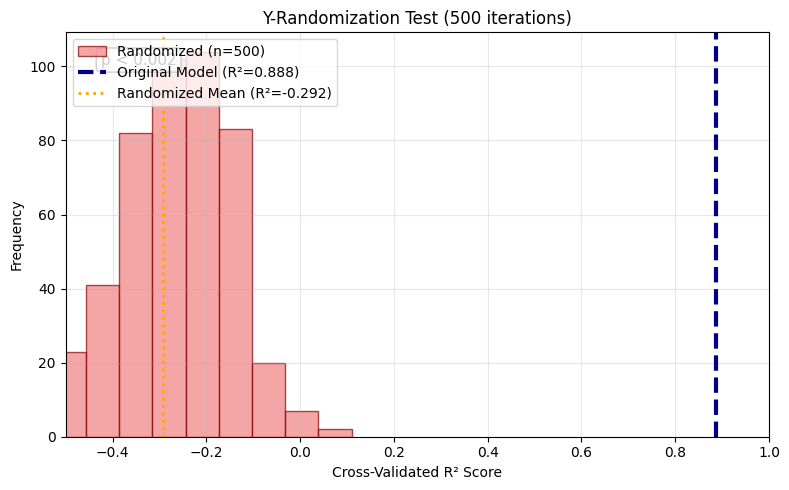

📈 Plot saved: y_randomization.png

Y-RANDOMIZATION RESULTS
Original Model R²: 0.8880

Randomized Models (500 iterations):
  Mean R²: -0.2917 ± 0.1654
  Range: [-1.3062, 0.1097]
  Better than original: 0/500

Statistical Significance:
  p < 0.002
  ✅ Significant (p < 0.05)


Explicit P-value: 0.0020


In [ ]:
def plot_y_randomization(results, save_path='y_randomization.png'):
  plt.figure(figsize=(8, 5))

  # Histogram
  plt.hist(results['randomized_scores'], bins=20, alpha=0.7, color='lightcoral', edgecolor='darkred', label=f'Randomized (n={results["n_iterations"]})')

  # Original model line
  plt.axvline(results['original_r2'], color='darkblue', linestyle='--', linewidth=3, label=f'Original Model (R²={results["original_r2"]:.3f})')

  # Randomized mean line
  plt.axvline(results['mean_randomized_r2'], color='orange', linestyle=':', linewidth=2, label=f'Randomized Mean (R²={results["mean_randomized_r2"]:.3f})')

  # Add p-value
  plt.text(0.05, 0.95, results['p_value_report'], transform=plt.gca().transAxes, fontsize=11, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.9))

  plt.xlabel('Cross-Validated R² Score')
  plt.ylabel('Frequency')
  plt.title(f'Y-Randomization Test ({results["n_iterations"]} iterations)')
  plt.legend(loc='upper left')
  plt.grid(True, alpha=0.3)
  plt.xlim(-0.5, 1.0)

  plt.tight_layout()
  plt.savefig(save_path, dpi=300, bbox_inches='tight')
  plt.show()
  print(f"📈 Plot saved: {save_path}")

def print_y_randomization_report_only(results):
  print("\n" + "="*50)
  print("Y-RANDOMIZATION RESULTS")
  print("="*50)

  print(f"Original Model R²: {results['original_r2']:.4f}")
  print(f"\nRandomized Models ({results['n_iterations']} iterations):")
  print(f"  Mean R²: {results['mean_randomized_r2']:.4f} \u00B1 {results['std_randomized_r2']:.4f}")
  print(f"  Range: [{results['min_randomized_r2']:.4f}, {results['max_randomized_r2']:.4f}]")
  print(f"  Better than original: {results['n_better']}/{results['n_iterations']}")
  print(f"\nStatistical Significance:")
  print(f"  {results['p_value_report']}")

  if results['p_value'] < 0.05:
      print("  \u2705 Significant (p < 0.05)")
  else:
      print("  \u26A0\uFE0F  Not significant (p \u2265 0.05)")

  print("\n" + "="*50)

# Run Y-randomization
# Use the R2_cv from the pls_results generated earlier as the original_model_r2
y_randomization_results = run_y_randomization(X, y, original_model_r2=original_model_r2, n_components=7, n_folds=5, n_iterations=500, random_state=42)

# Plot and print the results
plot_y_randomization(y_randomization_results)
print_y_randomization_report_only(y_randomization_results)

# Explicitly print the p-value as requested
print(f"\nExplicit P-value: {y_randomization_results['p_value']:.4f}")